自分用メモ  
LightGBMでモデリングした際に使いそうなexample

公式githubにあるnotebookがベース
https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.ipynb

In [54]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# print the JS visualization code to the notebook
shap.initjs()

# データ読み込み

Adult Data Set https://archive.ics.uci.edu/ml/datasets/adult  
incomeが50k超えたらTrue

Note: 文字列で学習させたモデルを入れるとバグる関数が多発するので、一回数字に置換した後の学習を行うことを推奨

In [138]:
# 文字列を含む
X, y = shap.datasets.adult(display=True)

# 文字列を置換済
X_num, _  = shap.datasets.adult()



categorical = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
# for col in categorical:
#     X[col] = X[col].astype('category')
#     X_num[col] = X_num[col].astype('category')

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=7)

d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical, free_raw_data=False)
d_test = lgb.Dataset(X_test, label=y_test,  categorical_feature=categorical, free_raw_data=False)

d_train_num = lgb.Dataset(X_train_num, label=y_train, categorical_feature=categorical, free_raw_data=False)
d_test_num = lgb.Dataset(X_test_num, label=y_test,  categorical_feature=categorical, free_raw_data=False)

print(X_train.shape, X_test.shape)
X_train.head()

(26048, 12) (6513, 12)


Age     Workclass  Education-Num  Marital Status          Occupation  \
12011  51.0       Private           10.0        Divorced   Handlers-cleaners   
23599  51.0   Federal-gov           14.0         Widowed               Sales   
23603  21.0       Private           11.0   Never-married        Craft-repair   
6163   25.0       Private           10.0   Never-married               Sales   
14883  48.0       Private           13.0        Divorced        Adm-clerical   

         Relationship    Race      Sex  Capital Gain  Capital Loss  \
12011   Not-in-family   White   Female           0.0           0.0   
23599       Unmarried   White     Male           0.0           0.0   
23603       Own-child   Black     Male           0.0           0.0   
6163        Own-child   White     Male           0.0           0.0   
14883       Own-child   White     Male           0.0           0.0   

       Hours per week         Country  
12011            40.0         Ireland  
23599            50.0     El-Salvador  
23603            40.0   United-States  
6163             24.0   United-States  
14883            38.0   United-States

In [139]:
X_train_num.head()

Age  Workclass  Education-Num  Marital Status  Occupation  \
12011  51.0          4           10.0               0           6   
23599  51.0          1           14.0               6          12   
23603  21.0          4           11.0               4           3   
6163   25.0          4           10.0               4          12   
14883  48.0          4           13.0               0           1   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
12011             0     4    0           0.0           0.0            40.0   
23599             1     4    1           0.0           0.0            50.0   
23603             3     2    1           0.0           0.0            40.0   
6163              3     4    1           0.0           0.0            24.0   
14883             3     4    1           0.0           0.0            38.0   

       Country  
12011       21  
23599        8  
23603       39  
6163        39  
14883       39

In [140]:
X_train.dtypes

Age                float32
Workclass         category
Education-Num      float32
Marital Status    category
Occupation        category
Relationship      category
Race              category
Sex               category
Capital Gain       float32
Capital Loss       float32
Hours per week     float32
Country           category
dtype: object

In [141]:
X_train_num.dtypes

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int64
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

# 学習

2値分類

In [142]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_clf = lgb.train(params, d_train, 10000, valid_sets=[d_train, d_test], early_stopping_rounds=50, verbose_eval=200)
model_clf_num = lgb.train(params, d_train_num, 10000, valid_sets=[d_train_num, d_test_num], early_stopping_rounds=50, verbose_eval=200)

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 50 rounds.
[200]	training's binary_logloss: 0.273707	valid_1's binary_logloss: 0.284647
[400]	training's binary_logloss: 0.263595	valid_1's binary_logloss: 0.278299
[600]	training's binary_logloss: 0.257553	valid_1's binary_logloss: 0.277039
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.25676	valid_1's binary_logloss: 0.276986
Training until validation scores don't improve for 50 rounds.
[200]	training's binary_logloss: 0.273707	valid_1's binary_logloss: 0.284647
[400]	training's binary_logloss: 0.263595	valid_1's binary_logloss: 0.278299
[600]	training's binary_logloss: 0.257553	valid_1's binary_logloss: 0.277039
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.25676	valid_1's binary_logloss: 0.276986


In [143]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "mse",
    "metric": "mse",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_reg = lgb.train(params, d_train, 10000, valid_sets=[d_train, d_test], early_stopping_rounds=50, verbose_eval=200)
model_reg_num = lgb.train(params, d_train_num, 10000, valid_sets=[d_train_num, d_test_num], early_stopping_rounds=50, verbose_eval=200)

Training until validation scores don't improve for 50 rounds.
[200]	training's l2: 0.0889695	valid_1's l2: 0.092123
[400]	training's l2: 0.0865938	valid_1's l2: 0.0906059
[600]	training's l2: 0.0848663	valid_1's l2: 0.0900822
[800]	training's l2: 0.0836902	valid_1's l2: 0.0897084
[1000]	training's l2: 0.0826843	valid_1's l2: 0.0895213
Early stopping, best iteration is:
[1034]	training's l2: 0.0825506	valid_1's l2: 0.089511
Training until validation scores don't improve for 50 rounds.
[200]	training's l2: 0.0889695	valid_1's l2: 0.092123
[400]	training's l2: 0.0865938	valid_1's l2: 0.0906059
[600]	training's l2: 0.0848663	valid_1's l2: 0.0900822
[800]	training's l2: 0.0836902	valid_1's l2: 0.0897084
[1000]	training's l2: 0.0826843	valid_1's l2: 0.0895213
Early stopping, best iteration is:
[1034]	training's l2: 0.0825506	valid_1's l2: 0.089511


# 普通のimportance

In [5]:
def save_importances(importances_: pd.DataFrame):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(4, 4))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.show()

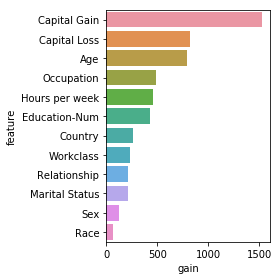

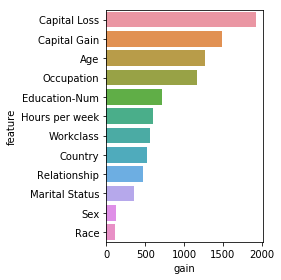

In [7]:
# 2値分類
importances = pd.DataFrame()
fold_ = 0
imp_df = pd.DataFrame()
imp_df['feature'] = X.columns
imp_df['gain'] = model_clf.feature_importance()
imp_df['fold'] = fold_ + 1
importances = pd.concat([importances, imp_df], axis=0, sort=False)
#  回帰
importances_reg = pd.DataFrame()
fold_ = 0
imp_df = pd.DataFrame()
imp_df['feature'] = X.columns
imp_df['gain'] = model_reg.feature_importance()
imp_df['fold'] = fold_ + 1
importances_reg = pd.concat([importances_reg, imp_df], axis=0, sort=False)

save_importances(importances)
save_importances(importances_reg)

# TreeExplainerの作成

https://shap.readthedocs.io/en/latest/#

In [145]:
explainer_clf_raw = shap.TreeExplainer(model_clf)
shap_values_clf_raw_train = explainer_clf_raw.shap_values(X_train)
shap_values_clf_raw_test = explainer_clf_raw.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


LightGBMの`model_output='probability'`は未対応の模様  (RFは未検証)
　参考: https://github.com/slundberg/shap/issues/480  
 なお、dataに文字列ありのpandasを渡すとnp.isnan関数でコケるので、さらにどうしようもない

In [170]:
explainer_clf_num = shap.TreeExplainer(model_clf_num,feature_dependence='independent', feature_perturbation='interventional', model_output='probability', data=X_train_num)

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.
Passing 26048 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


AttributeError: 'TreeEnsemble' object has no attribute 'values'

回帰

In [155]:
explainer_reg = shap.TreeExplainer(model_reg)
shap_values_reg_train = explainer_reg.shap_values(X_train)
shap_values_reg_test = explainer_reg.shap_values(X_test)
shap_values_reg_all = explainer_reg.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [164]:
# 回帰(数字置換後のデータ)
explainer_reg_num = shap.TreeExplainer(model_reg_num)
shap_values_reg_num_train = explainer_reg_num.shap_values(X_train_num)
shap_values_reg_num_test = explainer_reg_num.shap_values(X_test_num)
shap_values_reg_num_all = explainer_reg_num.shap_values(X_num)

In [11]:
# データ数×特徴量個の貢献度
shap_values_reg_train.shape

(26048, 12)

In [158]:
X_train.iloc[0,:]

Age                               51
Workclass                    Private
Education-Num                     10
Marital Status              Divorced
Occupation         Handlers-cleaners
Relationship           Not-in-family
Race                           White
Sex                           Female
Capital Gain                       0
Capital Loss                       0
Hours per week                    40
Country                      Ireland
Name: 12011, dtype: object

In [163]:
# 同じデータであれば、全データでshap valueを求めた値とtrainのみで求めた値は一致する
shap_values_reg_all[12011] == shap_values_reg_train[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

(26048, 12)

# force plot

個々の予測値への各変数の貢献度を可視化  
https://github.com/slundberg/shap/blob/master/shap/plots/force.py

分類

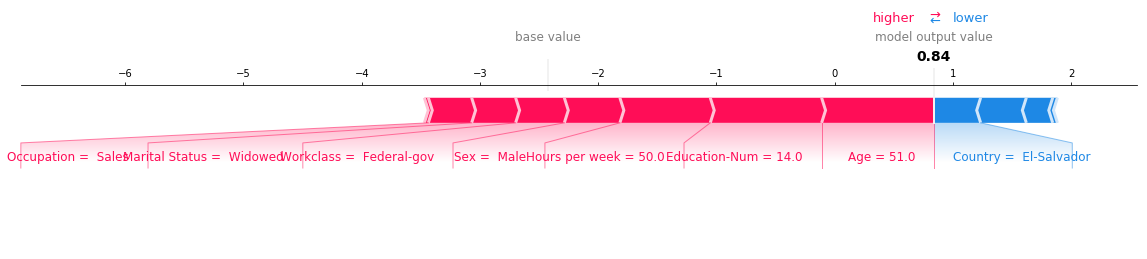

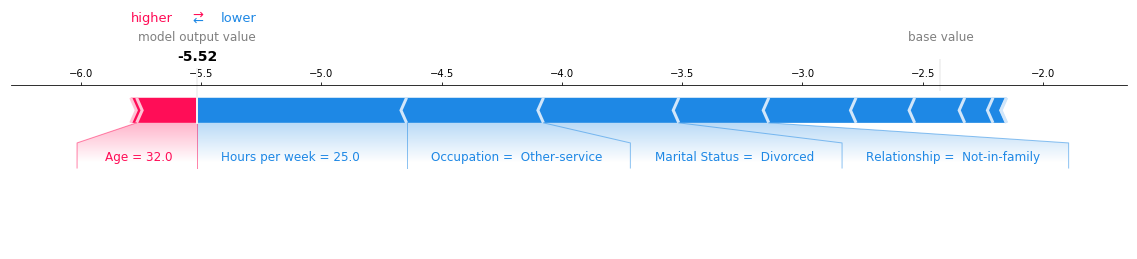

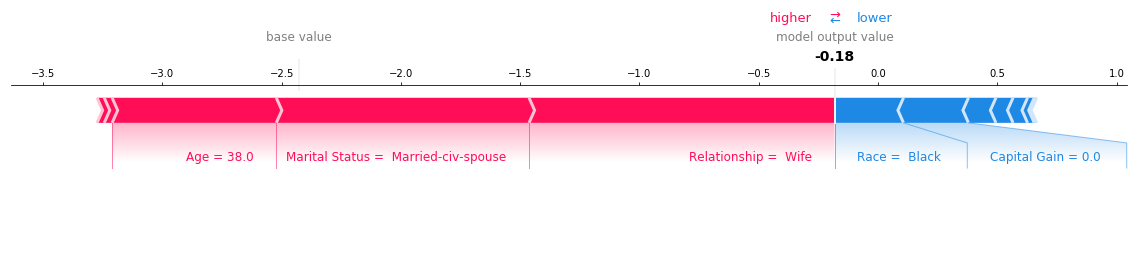

In [167]:
for i in [1, 12, 100]:
    shap.force_plot(
        # 2値分類なので、[1]にしていることに注意
        base_value=explainer_clf_raw.expected_value[1],  # ベースライン
        shap_values=shap_values_clf_raw_train[1][i, :],  # 対象データのshap value(i番目のデータを求める例)
        features=X_train.iloc[i, :],  # ここでこれを与えないと、特徴量の値が表示されない
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('force_plot_clf_{}.png'.format(i), dpi=250, bbox_inches='tight')

上記値は確率ではないことに注意。  
sigmoid関数に通す前の値

In [168]:
import math
def sigmoid(a):
    s = 1 / (1 + e**-a)
    return s

e = math.e
print(model_clf.predict(X_train.iloc[100:101, :]))
sigmoid(-0.18)

[0.45456441]


0.45512110762641994

回帰

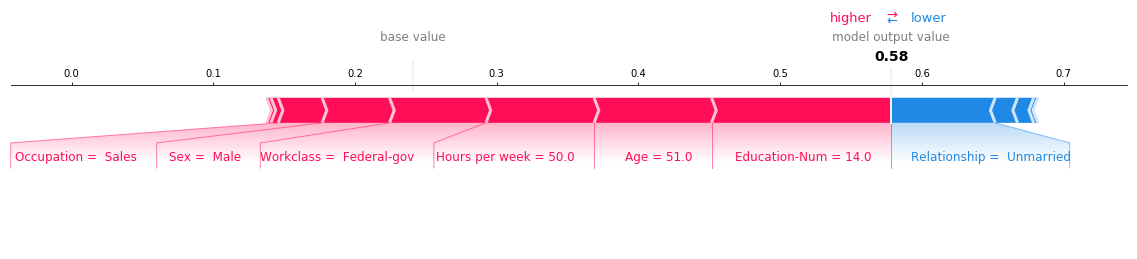

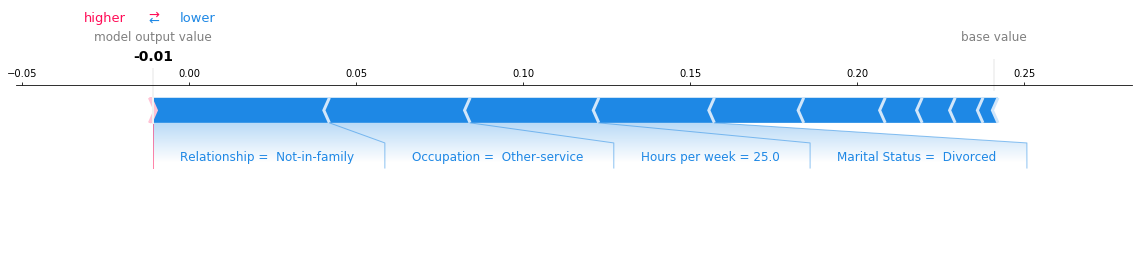

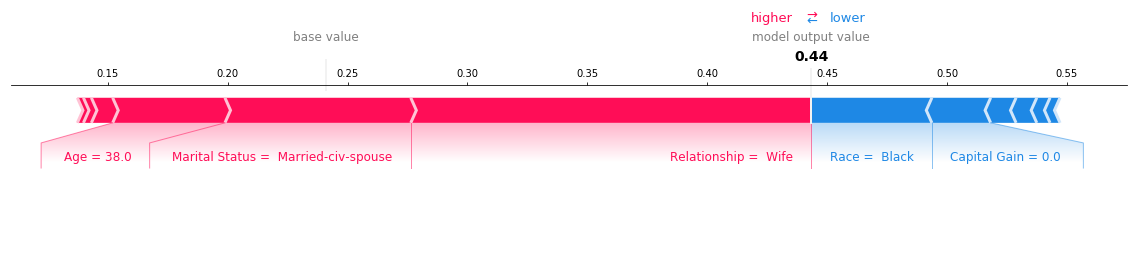

In [172]:
for i in [1, 12, 100]:
    shap.force_plot(
        explainer_reg.expected_value,  # ベースライン
        shap_values_reg_train[i, :],  # 対象データのshap value(i番目のデータを求める例)
        X_train.iloc[i, :],
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('force_plot_reg_{}.png'.format(i), dpi=250, bbox_inches='tight')

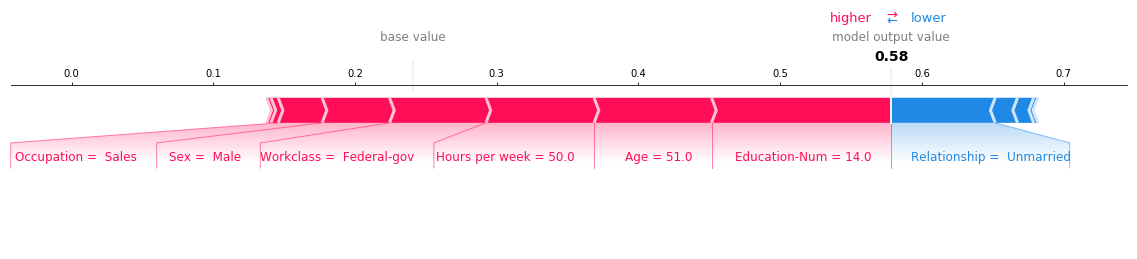

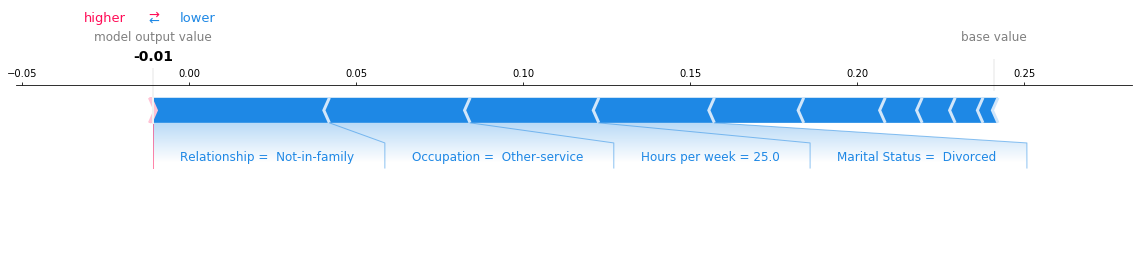

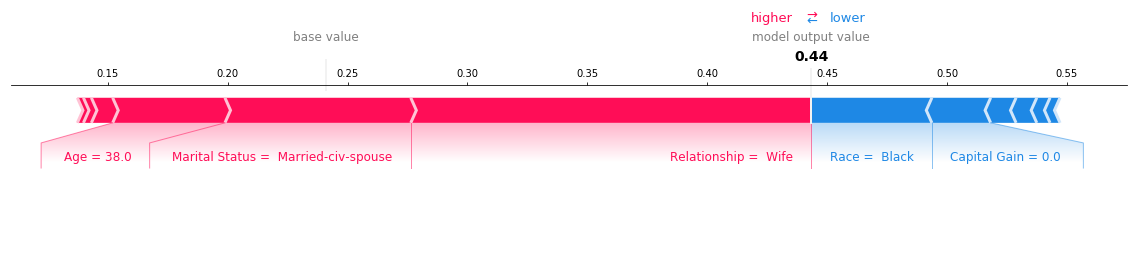

In [179]:
for i in [1, 12, 100]:
    shap.force_plot(
        explainer_reg_num.expected_value,  # ベースライン
        shap_values_reg_num_train[i, :],  # 対象データのshap value(i番目のデータを求める例)
        features=X_train.iloc[i, :],  # 素直に数値編後のpandasを入れると、データのカテゴリカル値が分からないので、あえて変換前のpandasを入力
        matplotlib=True,  # 　default Javascript output
        show=False).savefig('force_plot_reg_num_{}.png'.format(i),dpi=250,bbox_inches='tight')

ほぼ使わないと思うが、複数データをまとめて表示  
JSで動いてかっこいい

In [60]:

shap.force_plot(
    explainer_reg.expected_value,  # ベースライン
    shap_values_reg_train[:8, :],  # 対象データのshap value(i番目のデータを求める例)
    X_train.iloc[:8, :]  # 対象データ
)

# waterfall_plot
個々の予測値への各変数の貢献度を可視化

pngで書き出すのが難しそう。  
- 関数の中ではplt.show()しているだけ
- 公式のexampleに使用例がない
- (figを取り出したい。。。)

https://github.com/slundberg/shap/blob/master/shap/plots/waterfall.py

分類

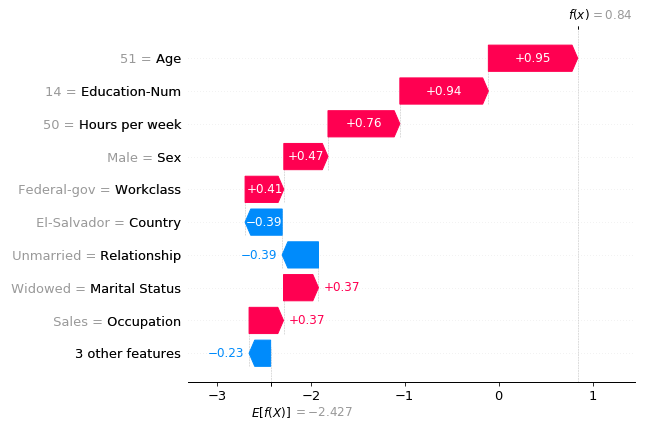

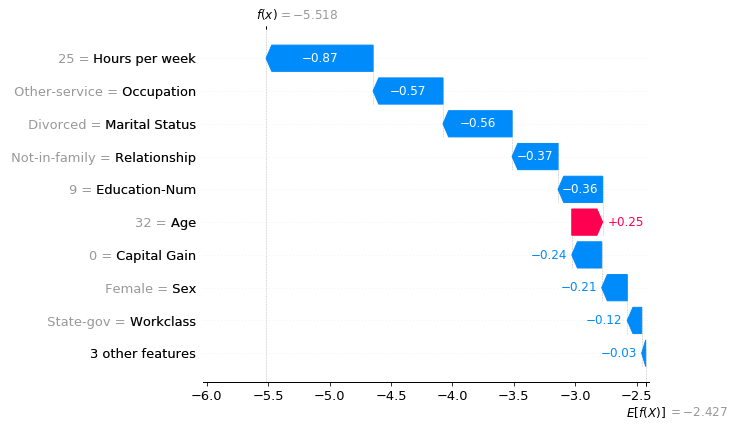

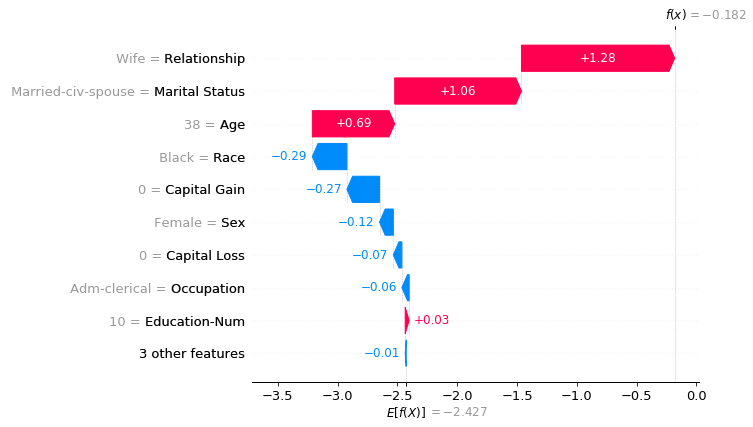

In [30]:
for i in [1, 12, 100]:
    shap.waterfall_plot(
        explainer_clf_raw.expected_value[1],
        shap_values_clf_raw_train[1][i, :],
        X_train.iloc[i, :])

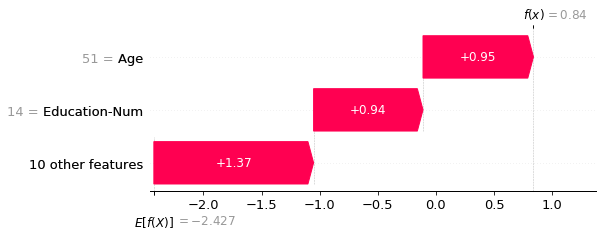

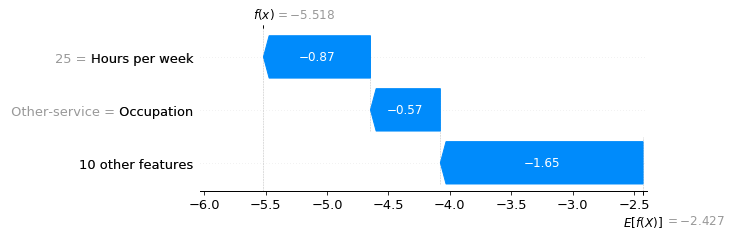

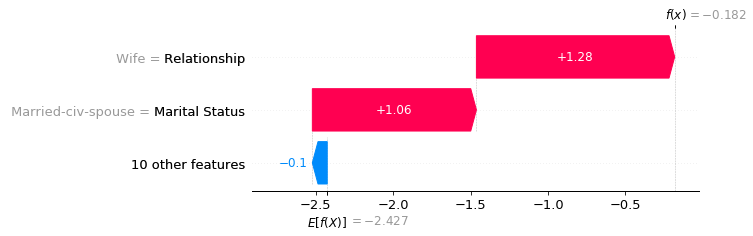

In [45]:
# 変数を絞りたい場合、max_displayを使うと便利(defalut=10)
for i in [1, 12, 100]:
    shap.waterfall_plot(
        explainer_clf_raw.expected_value[1],
        shap_values_clf_raw_train[1][i, :],
        X_train.iloc[i, :],
        max_display=3)

回帰

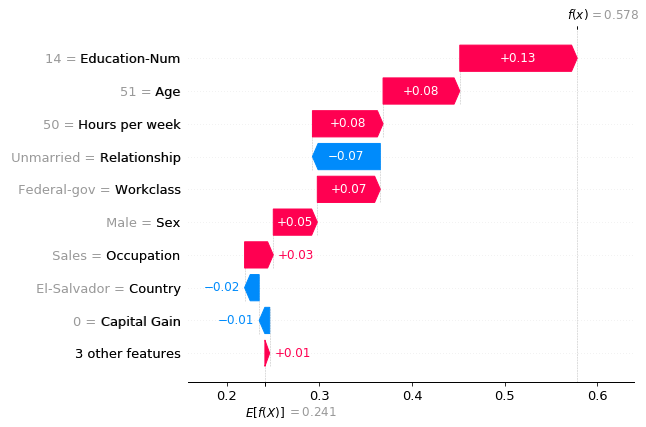

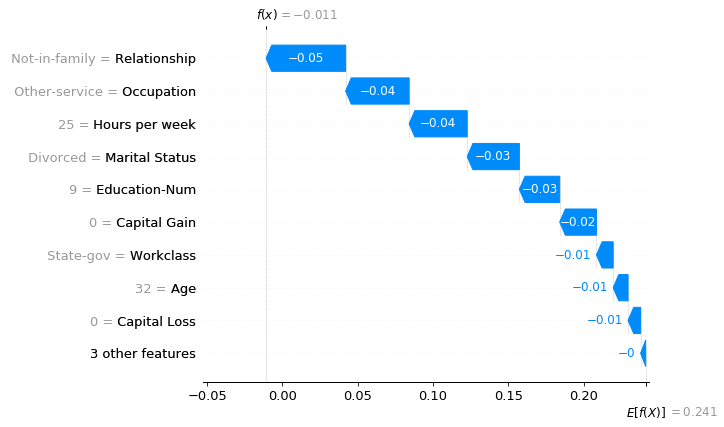

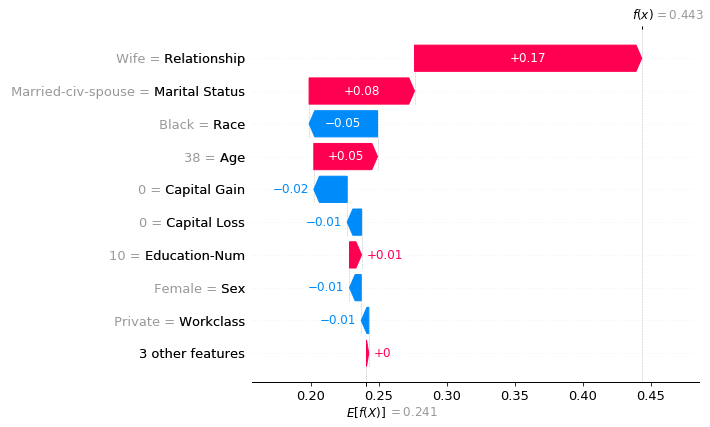

In [180]:
for i in [1, 12, 100]:
    shap.waterfall_plot(
        explainer_reg.expected_value,
        shap_values_reg_train[i, :],
        X_train.iloc[i, :])

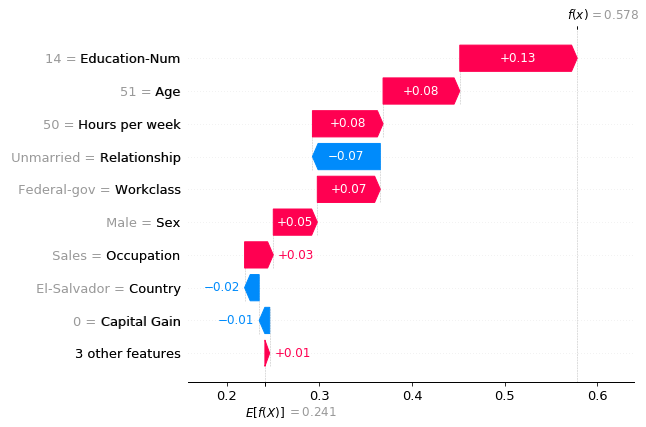

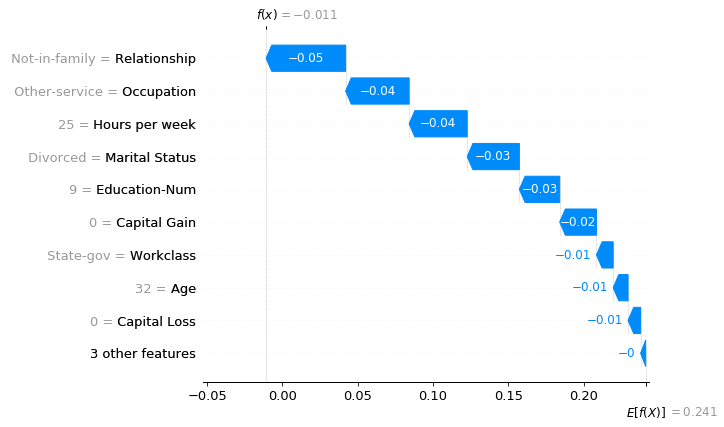

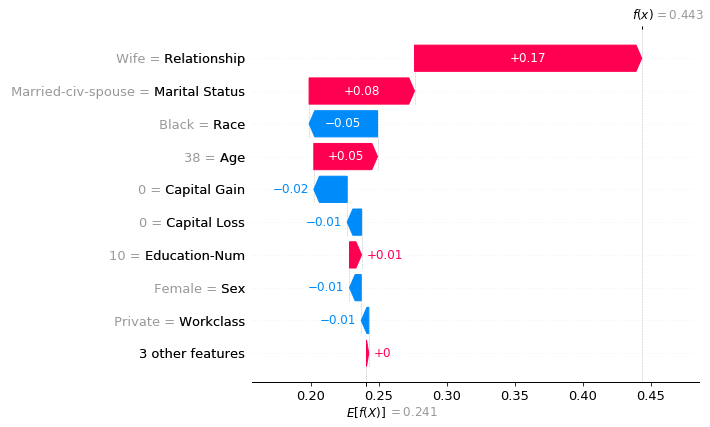

In [185]:
# 数値変換したpandasで構築したモデル
for i in [1, 12, 100]:
    shap.waterfall_plot(
        explainer_reg_num.expected_value,
        shap_values_reg_num_train[i, :],
        X_train.iloc[i, :] # Male, Femaleではなく、0,1で表示されてしまうのであえて。
    )

#  SHAP Summary Plot

https://github.com/slundberg/shap/blob/aee2310c21383f9462210c616b0a89c9ed4611a2/shap/plots/summary.py

これも、関数の中でplt.plot()しているだけなので、外からアクセスして書き出しは面倒？  
(figを取り出したい。。。)

分類

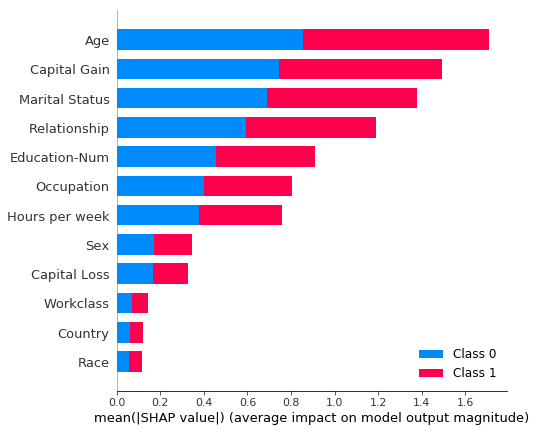

In [65]:
shap.summary_plot(shap_values_clf_raw_train, X_train, plot_size=(7,7))

回帰

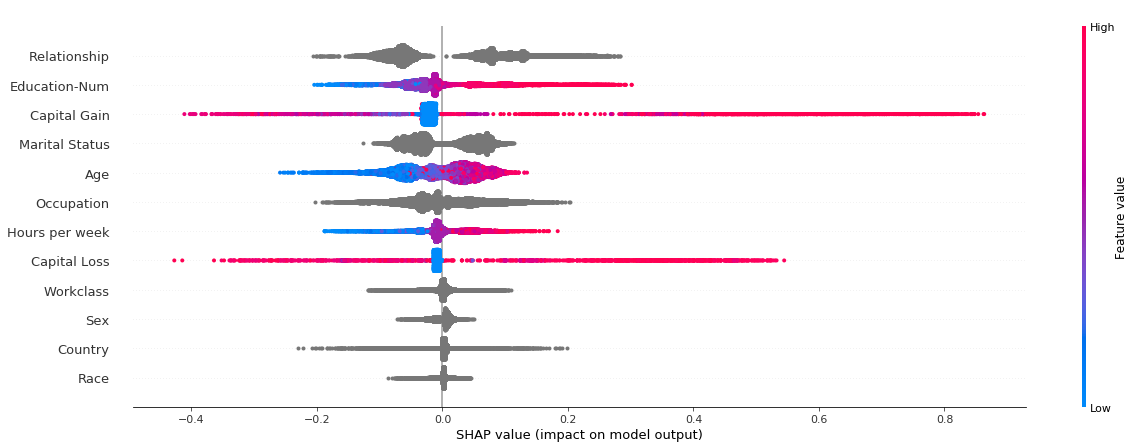

In [75]:
shap.summary_plot(shap_values_reg_train, X_train, plot_size=(20,7), show=False)

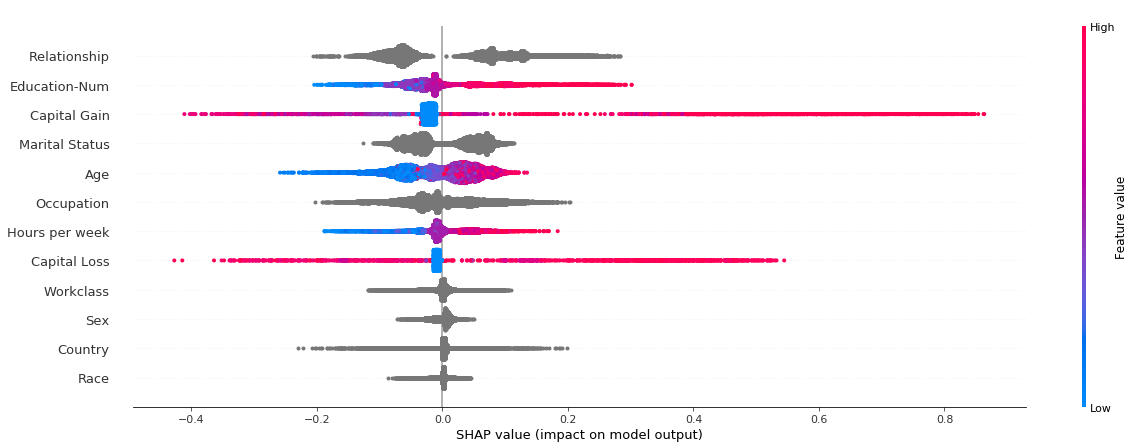

In [187]:
shap.summary_plot(shap_values_reg_num_train, X_train, plot_size=(20,7), show=False)

# Dependence Plot

https://github.com/slundberg/shap/blob/master/shap/plots/dependence.py

分類

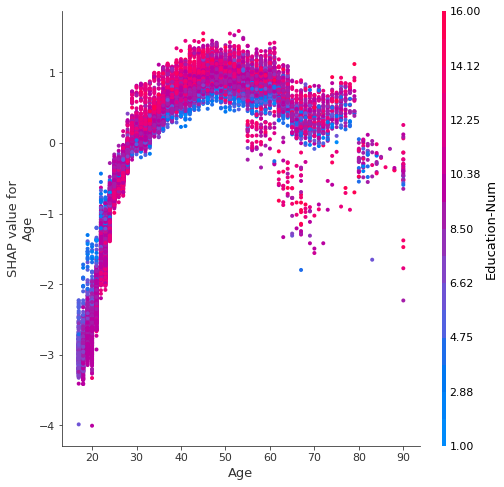

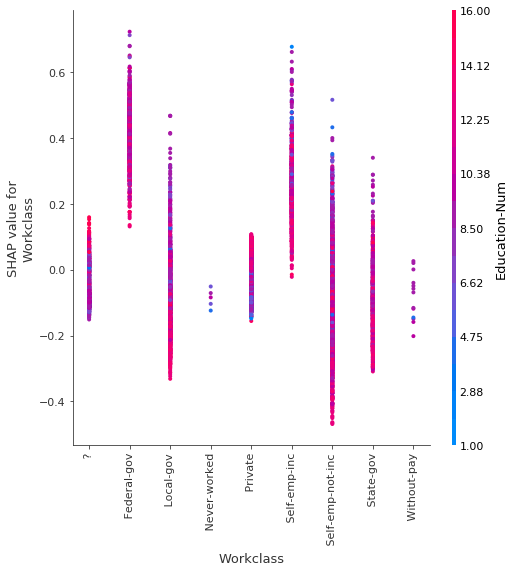

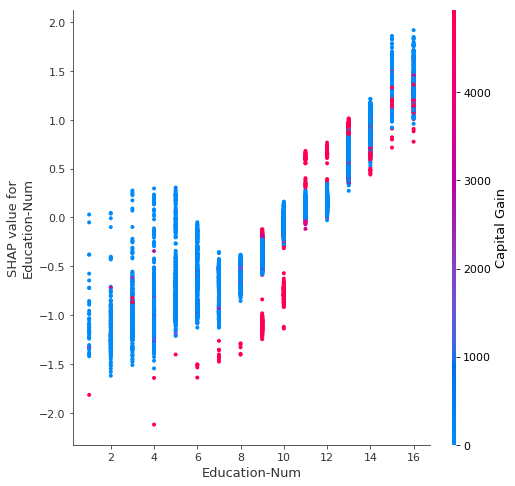

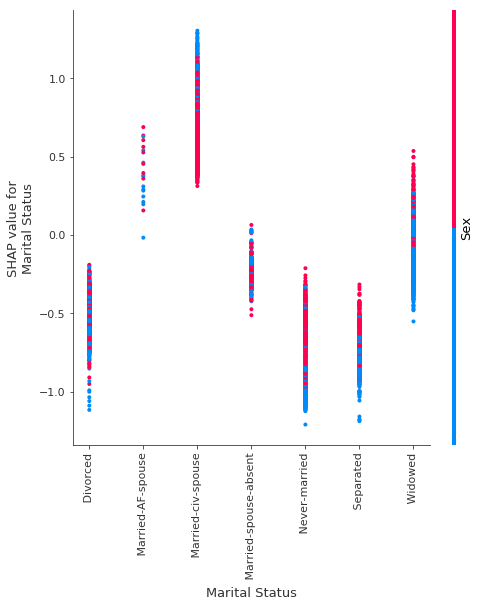

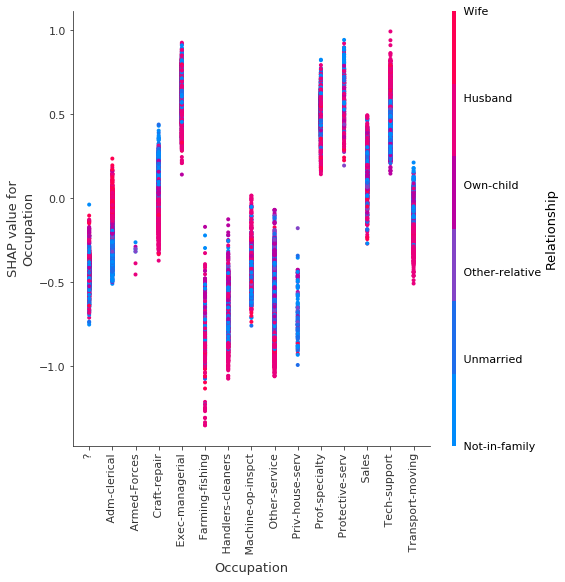

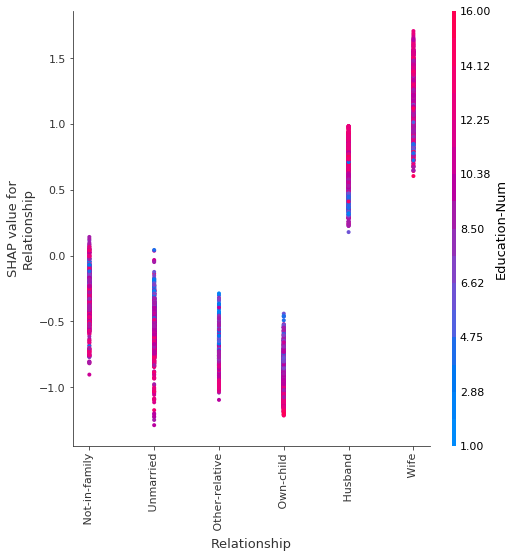

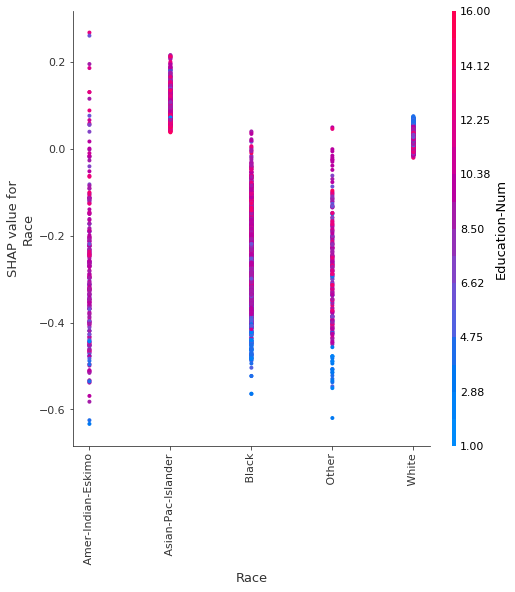

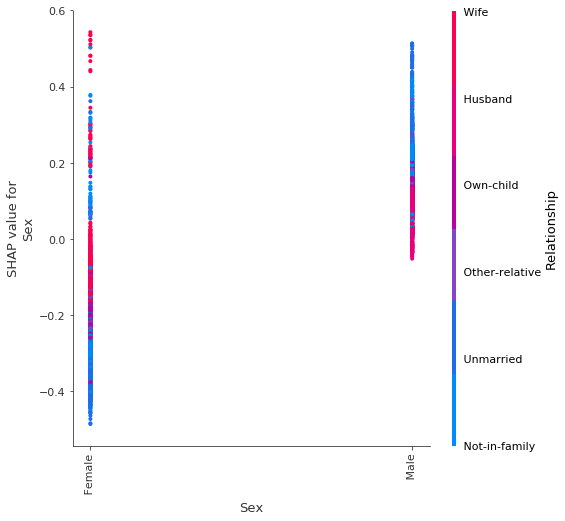

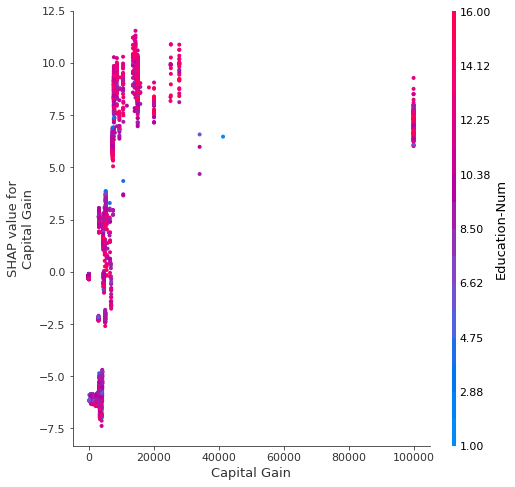

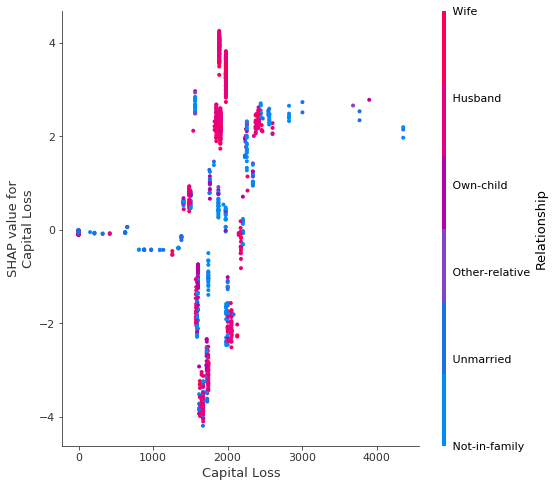

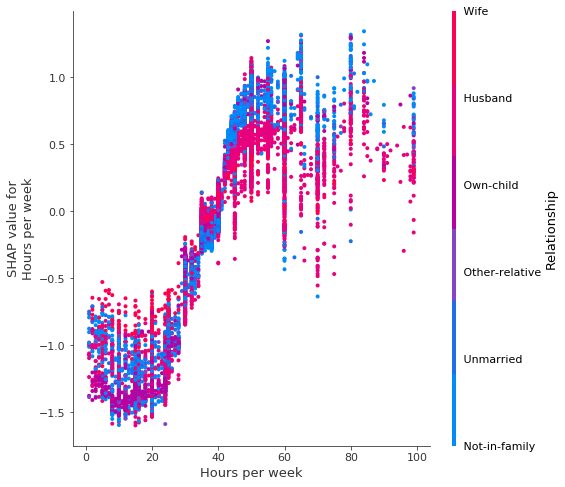

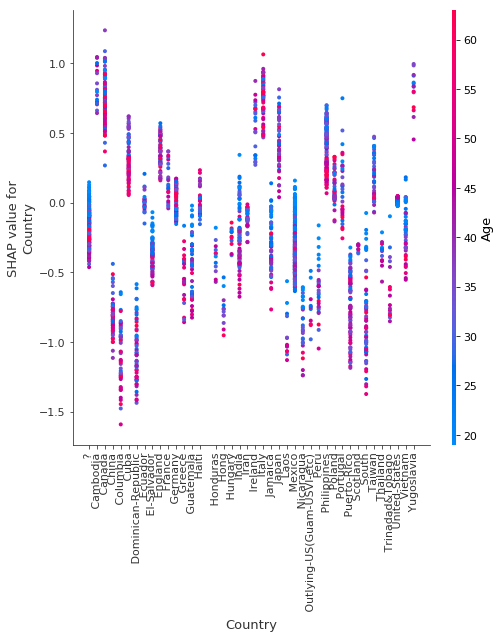

In [207]:
for col in X_train.columns:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    shap.dependence_plot(
        ind=col,
        shap_values=shap_values_clf_num_train[1],
        features=X_train_num,
        display_features=X_train,
        ax=ax)
    fig.savefig('dependence_plot_clf_{}.png'.format(col))

同時に表示する変数を明示的に指定することも可能
指定なしの場合は`shap.common.approximate_interaction`により how much interaction they seem to haveが計算され、最もinteractionがあるものが選択されるらしい  
https://github.com/slundberg/shap/blob/cde70feb211443cfbd9f599fcded8fe00b9d6a3d/shap/common.py#L278

縦に大きくブレる = そのあたい

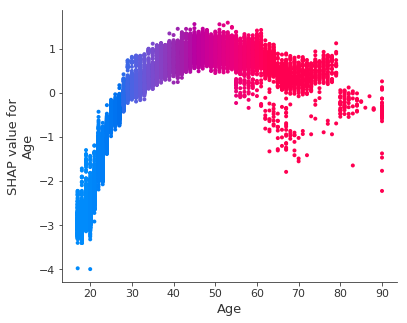

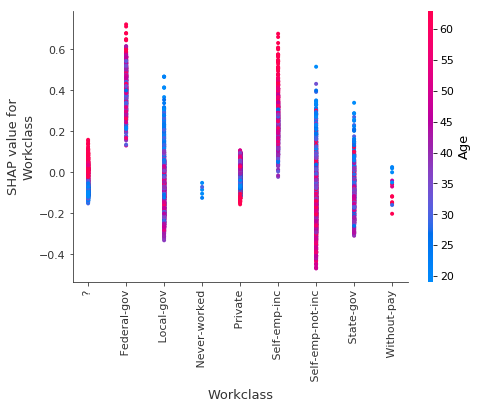

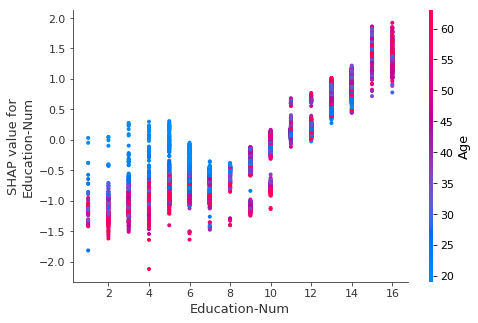

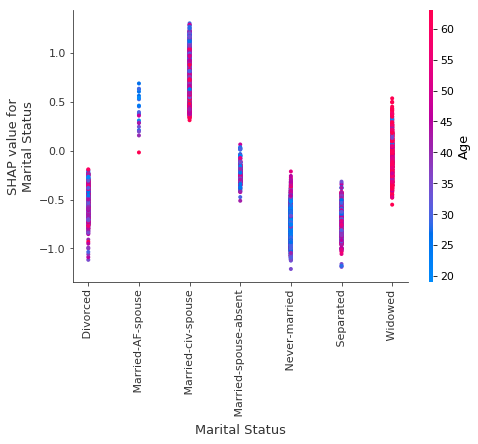

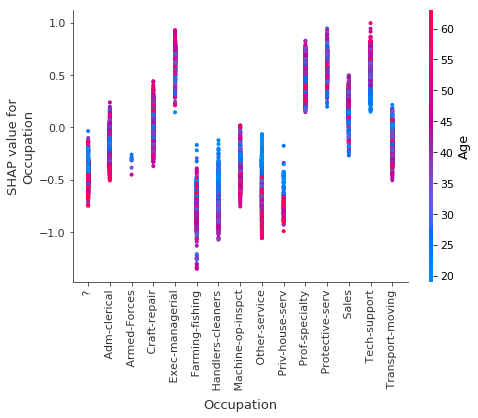

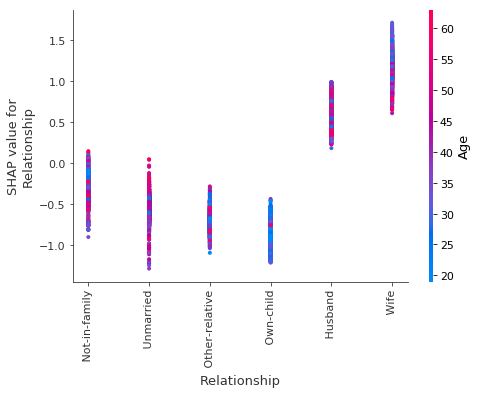

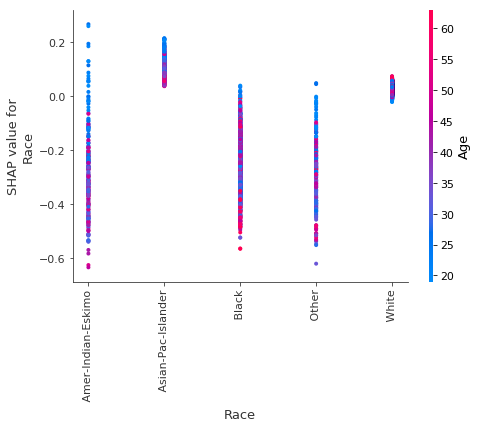

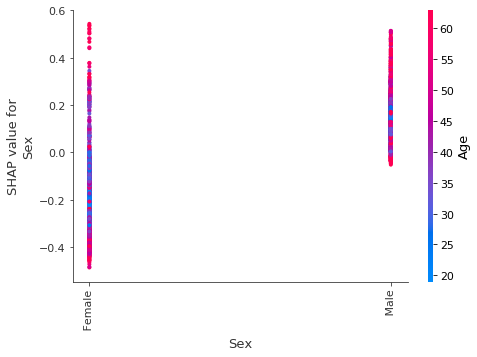

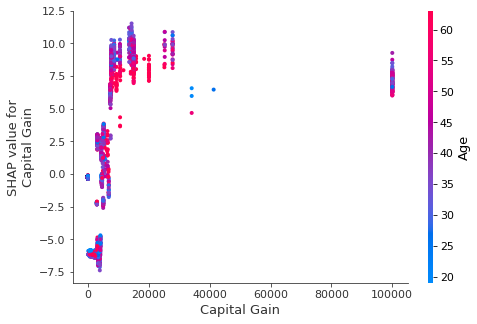

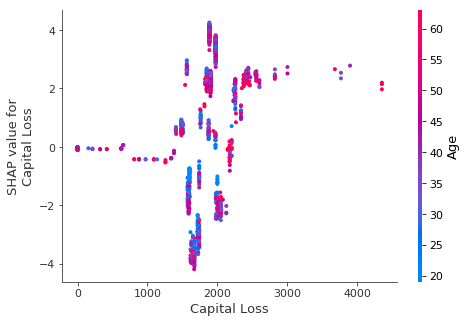

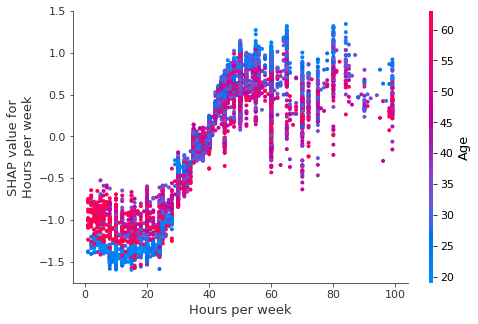

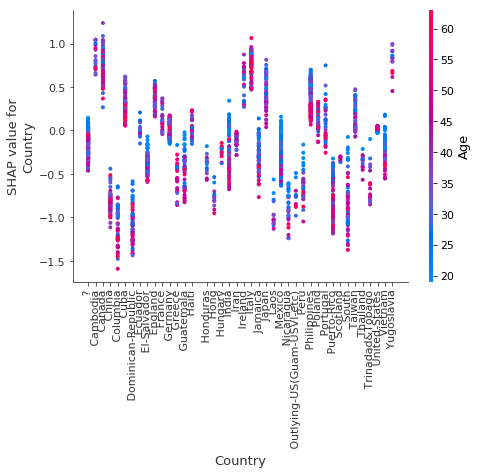

In [208]:
for col in X_train.columns:
    shap.dependence_plot(
        ind=col,
        shap_values=shap_values_clf_num_train[1],
        features=X_train_num,
        display_features=X_train,
        interaction_index='Age'
    )

iteraction_indexを自分自身にすれば、無駄な誤解は産みにくいシンプルな図になる  
(単純に赤ければ、その値が大きい)

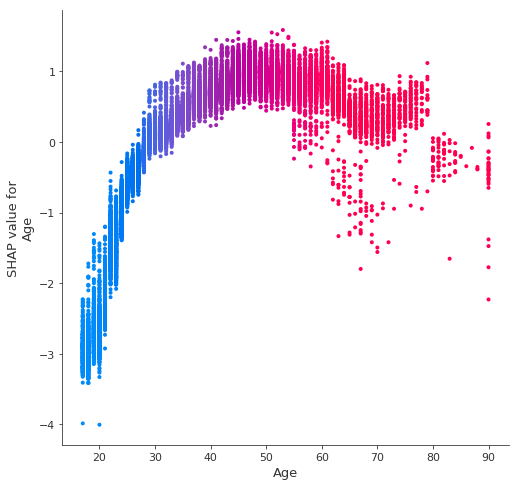

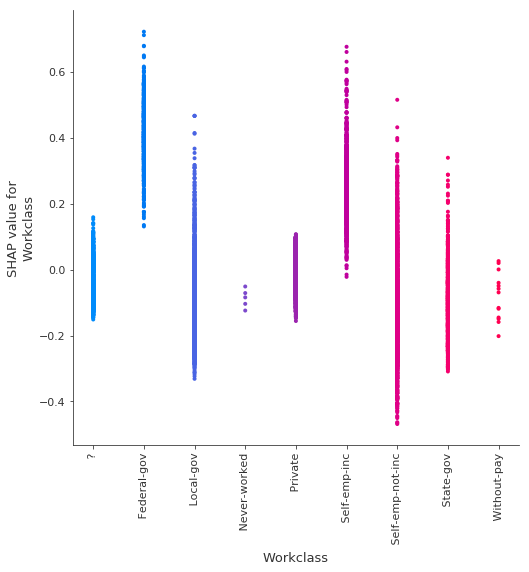

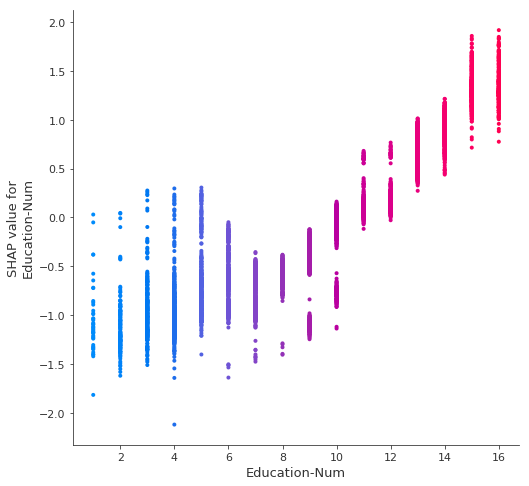

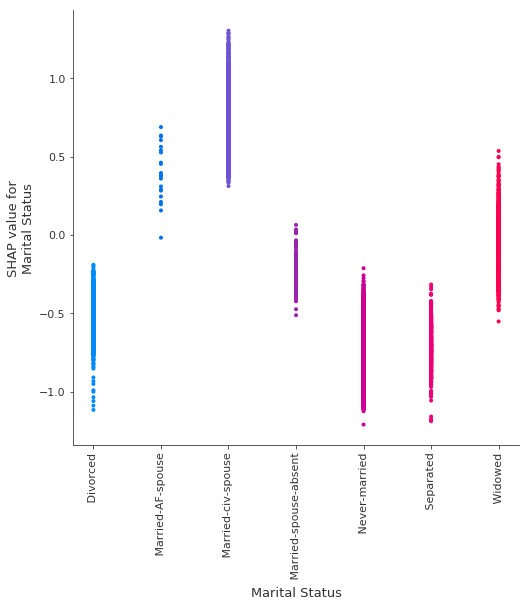

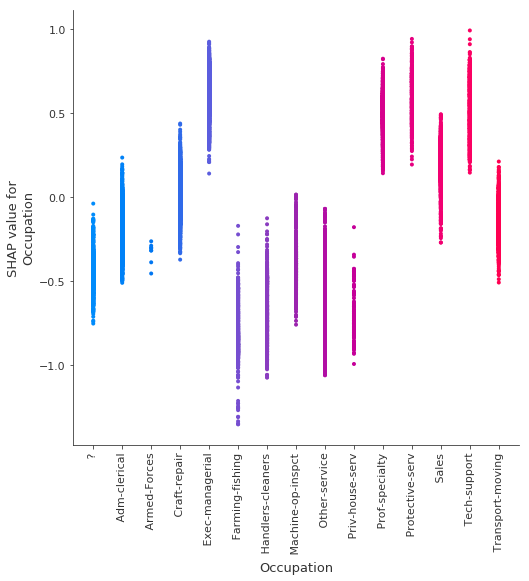

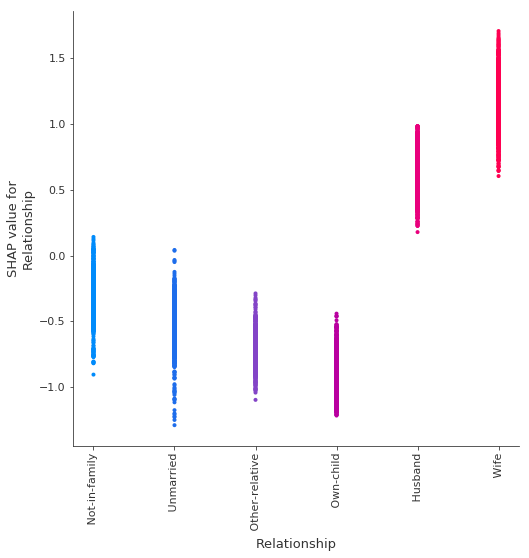

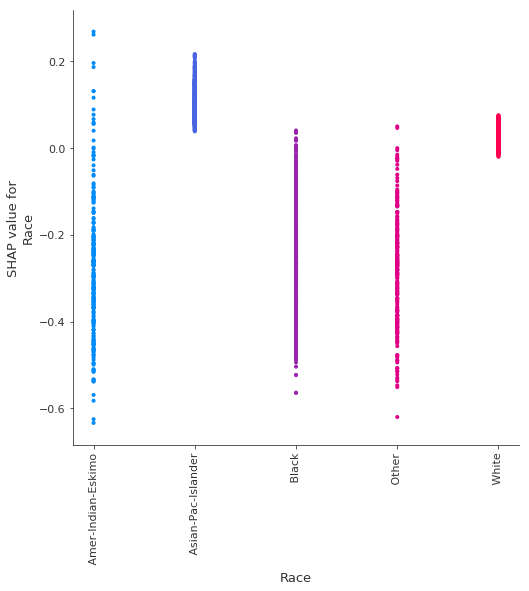

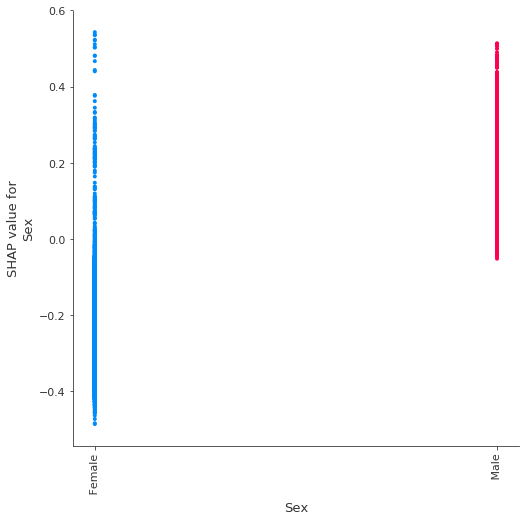

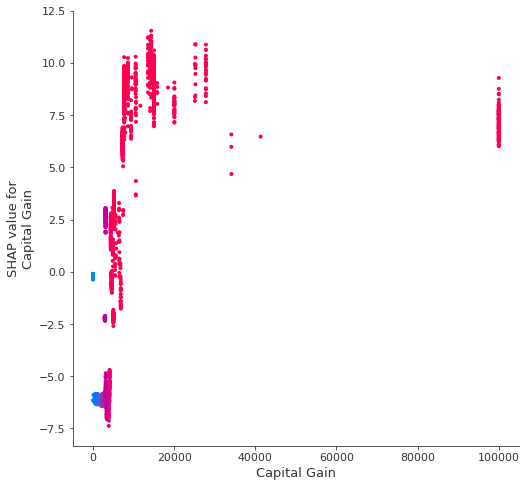

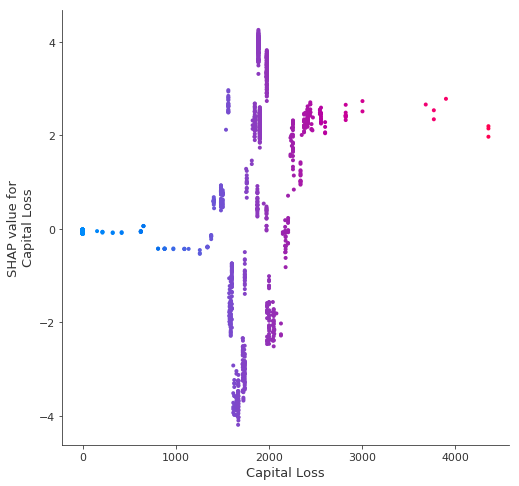

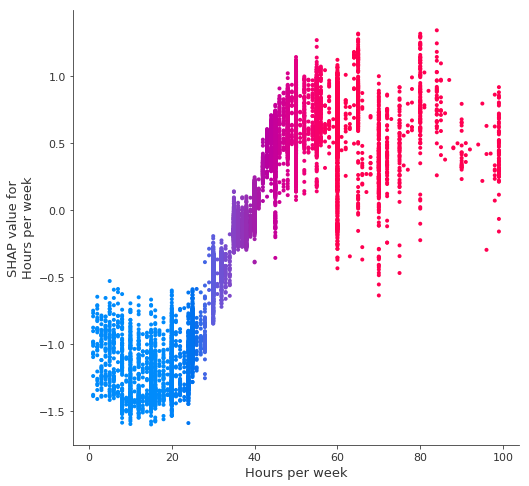

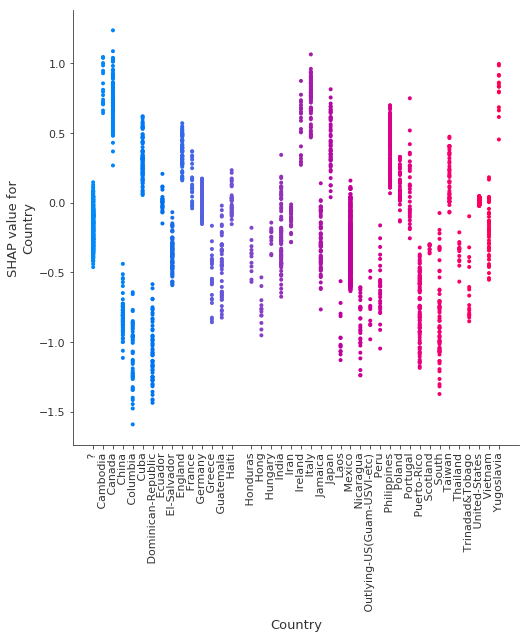

In [209]:
for col in X_train.columns:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    shap.dependence_plot(
        ind=col,
        shap_values=shap_values_clf_num_train[1],
        features=X_train_num,
        display_features=X_train,
        interaction_index=col,
        ax=ax)
    fig.savefig('dependence_plot_clf_only_{}.png'.format(col))

なお、文字列ありのpandasだとコケる

In [195]:
shap.dependence_plot('Age', shap_values_reg_train, X_train, display_features=X_train)

ValueError: could not convert string to float: ' Private'

回帰

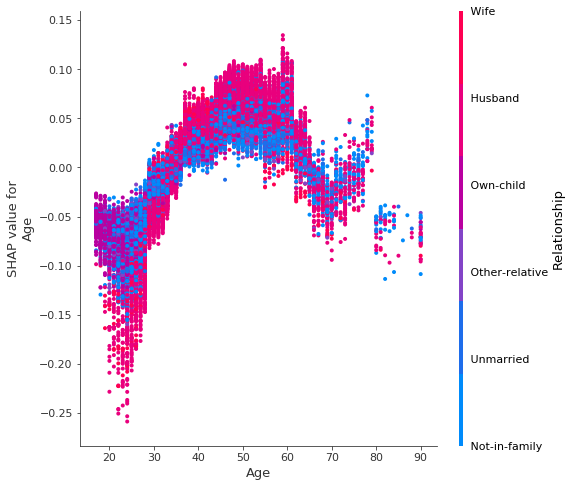

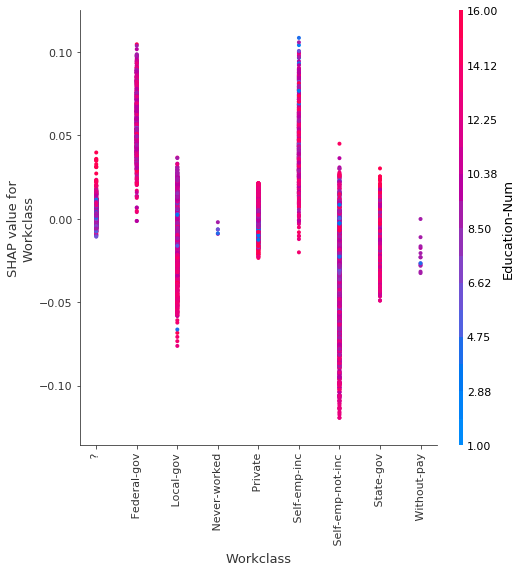

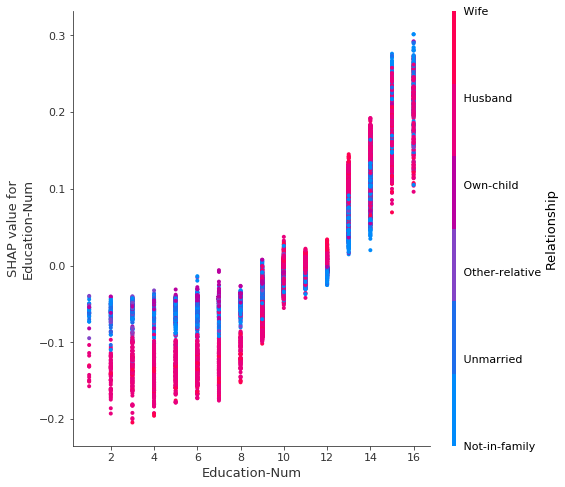

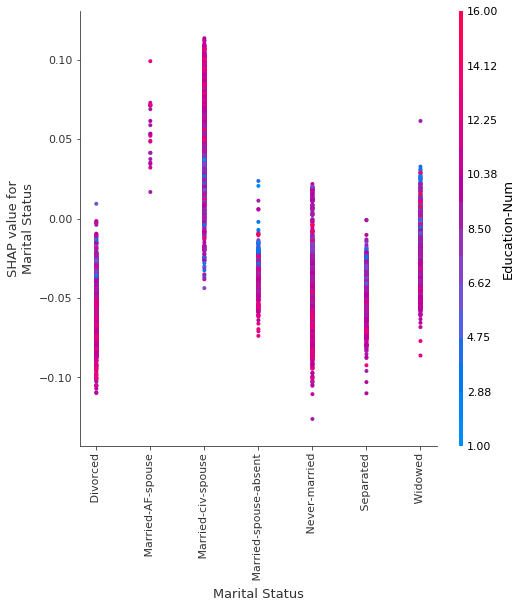

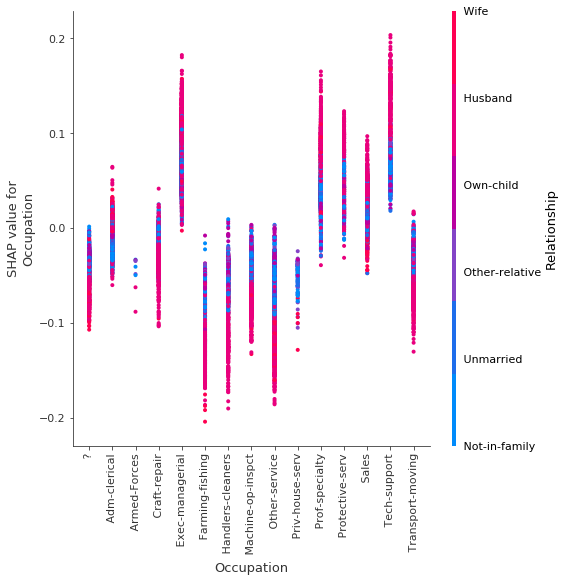

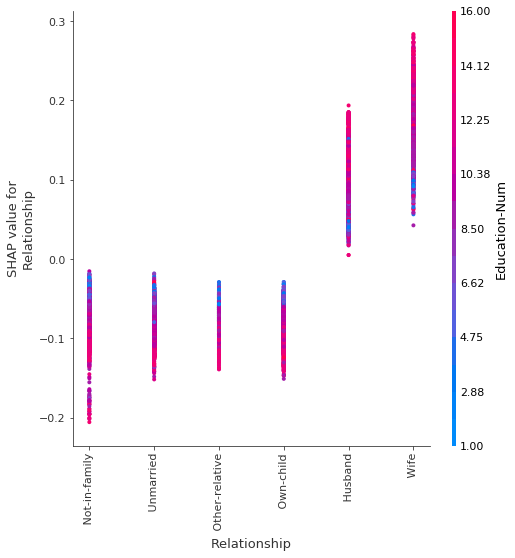

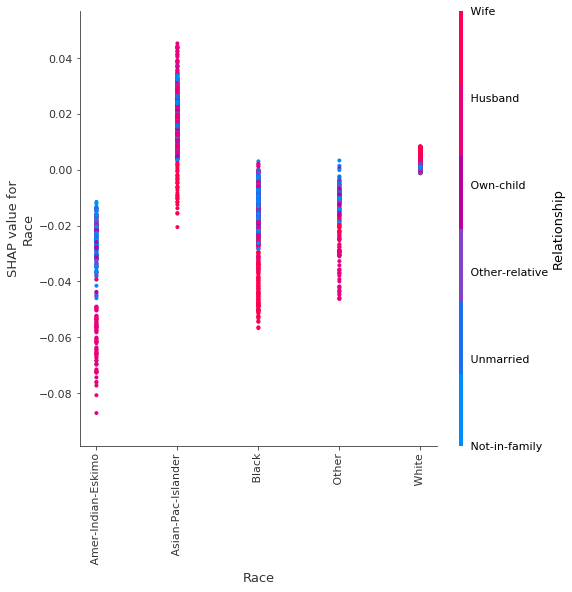

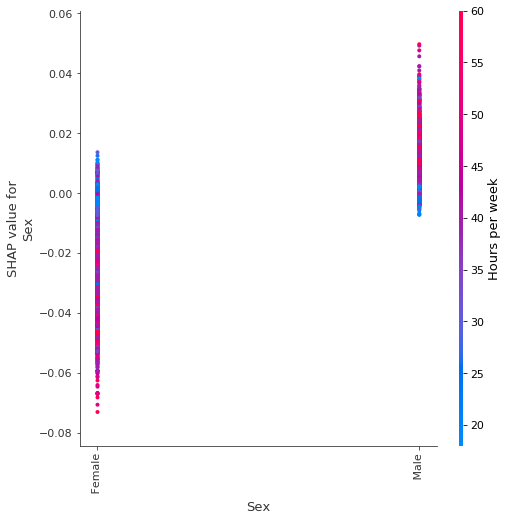

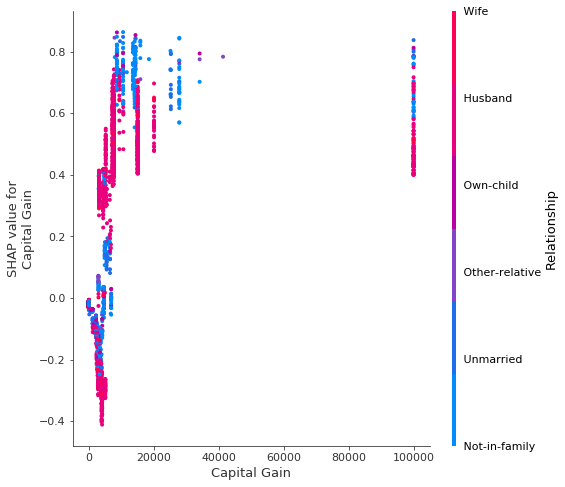

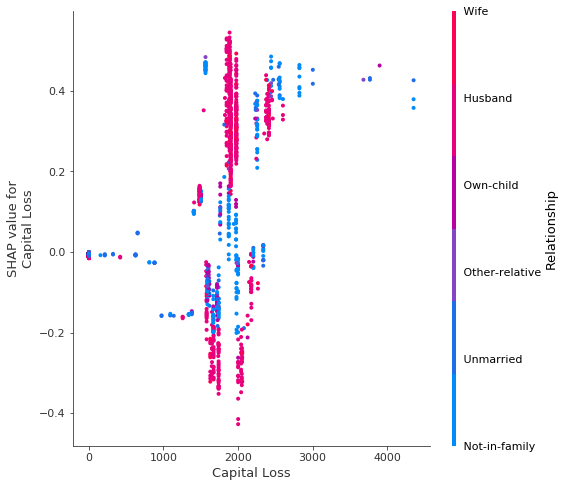

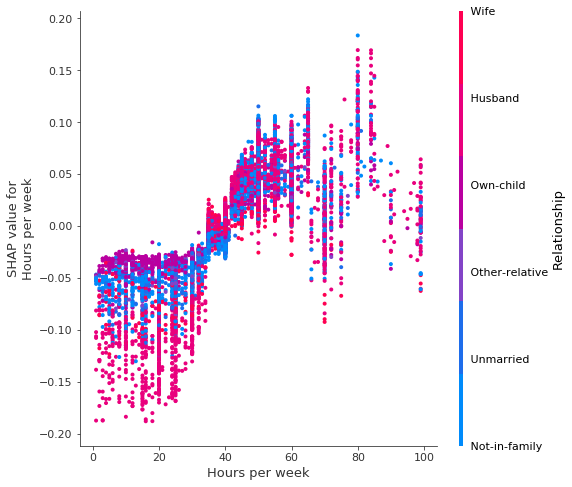

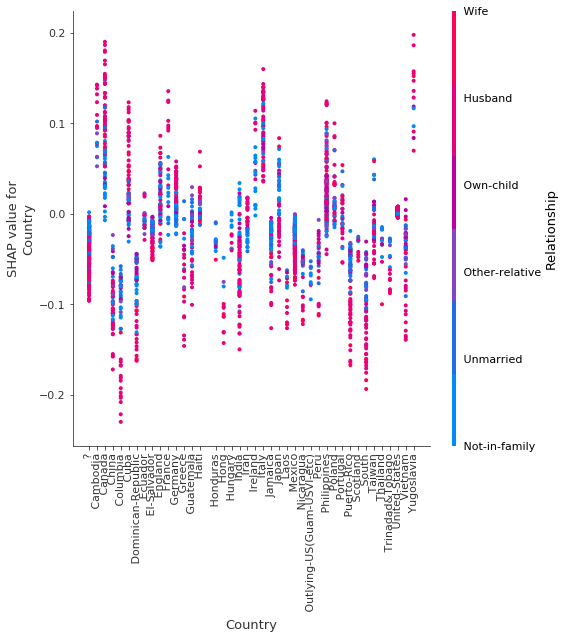

In [210]:
for col in X_train.columns:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    shap.dependence_plot(
        ind=col,
        shap_values=shap_values_reg_num_train,
        features=X_train_num,
        display_features=X_train,
        ax=ax)
    fig.savefig('dependence_plot_reg_{}.png'.format(col))

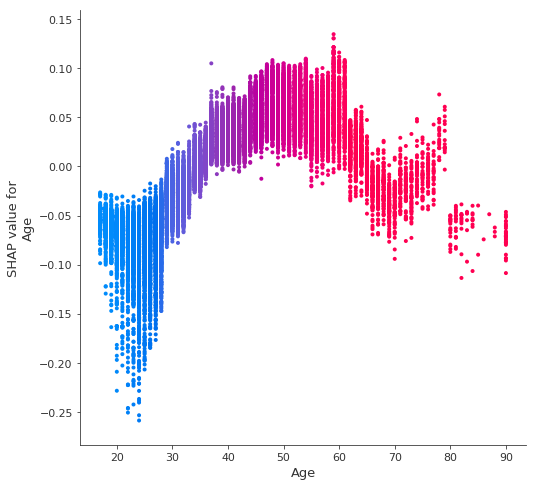

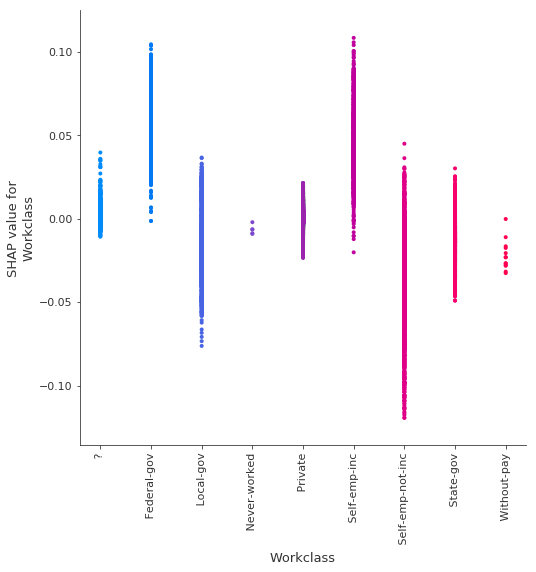

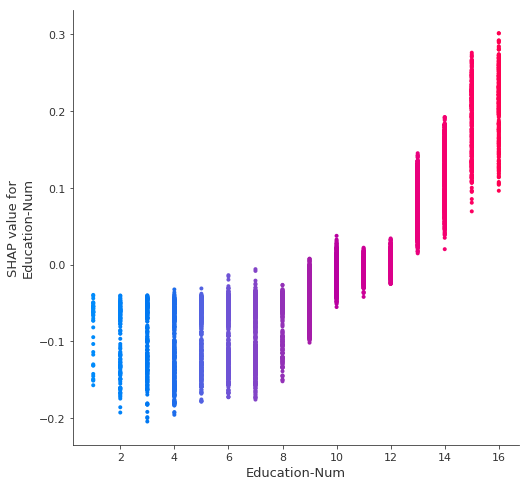

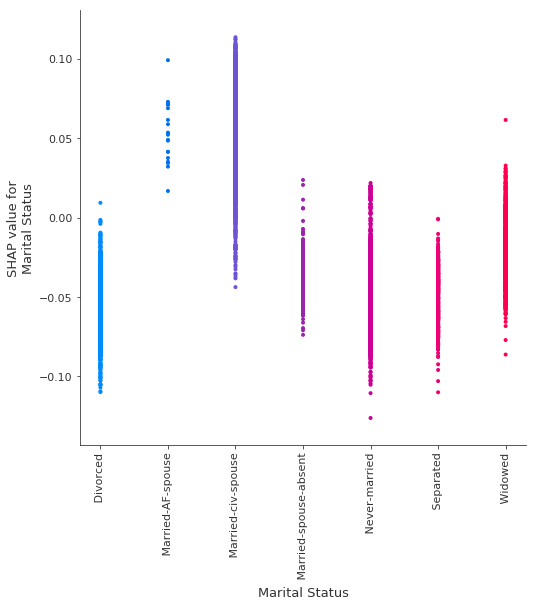

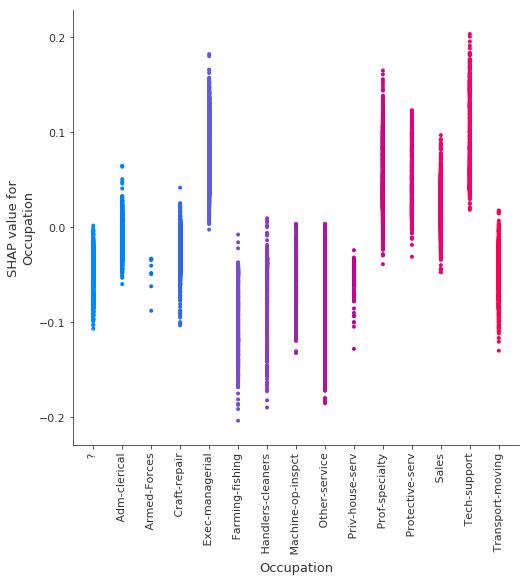

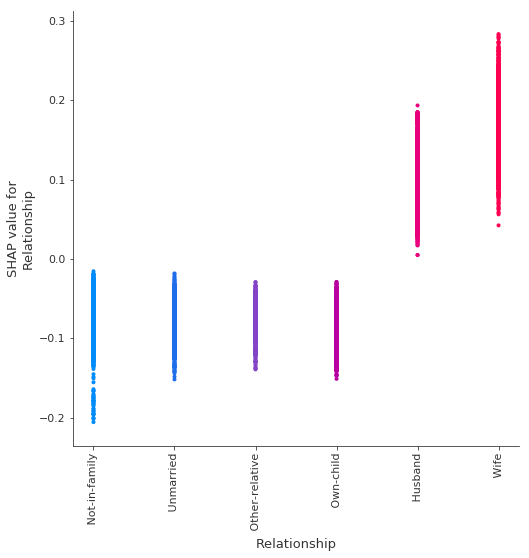

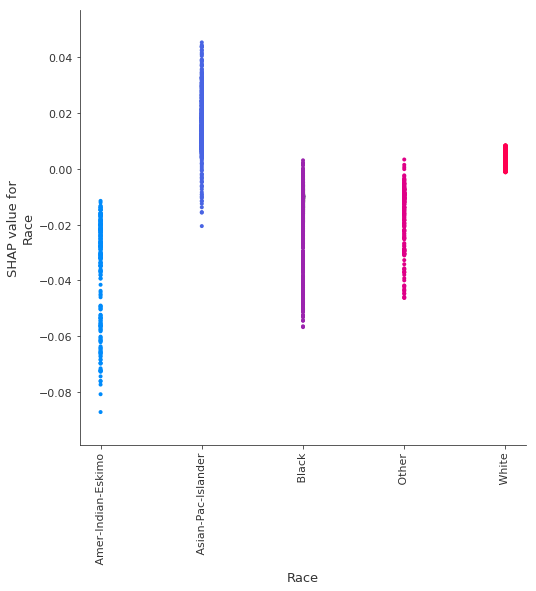

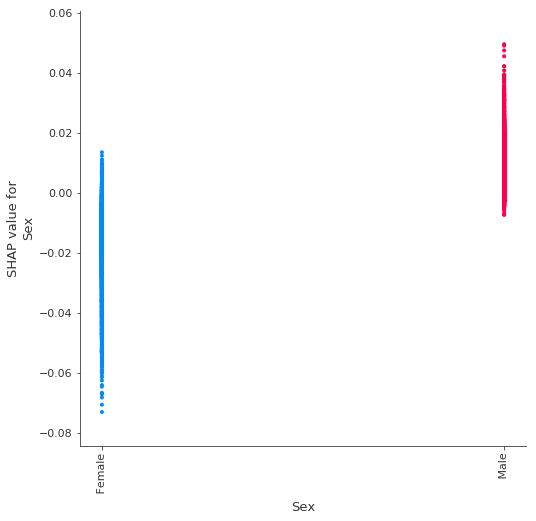

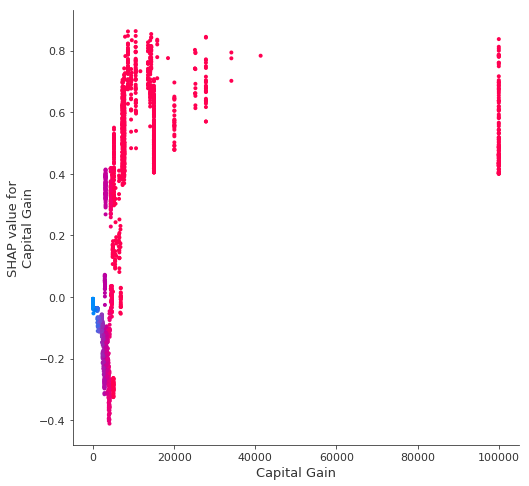

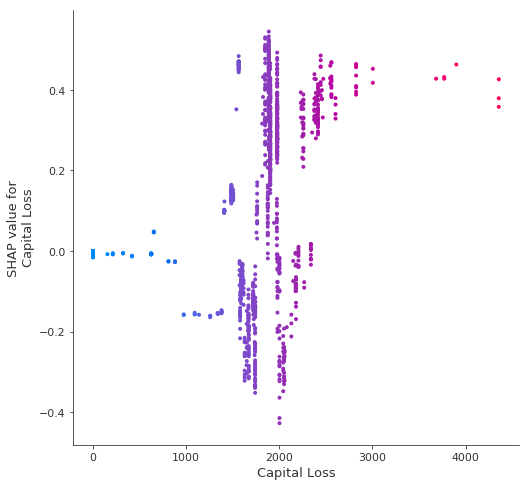

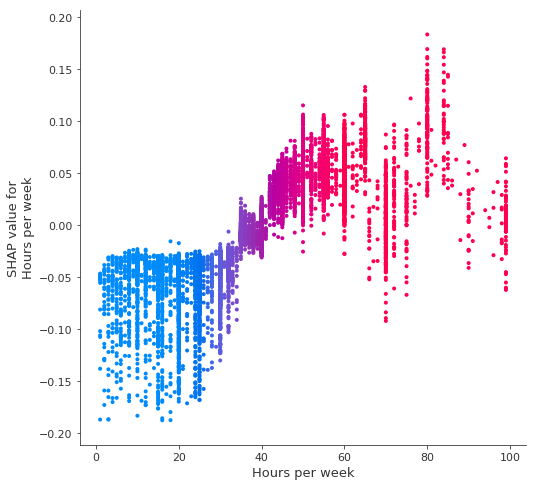

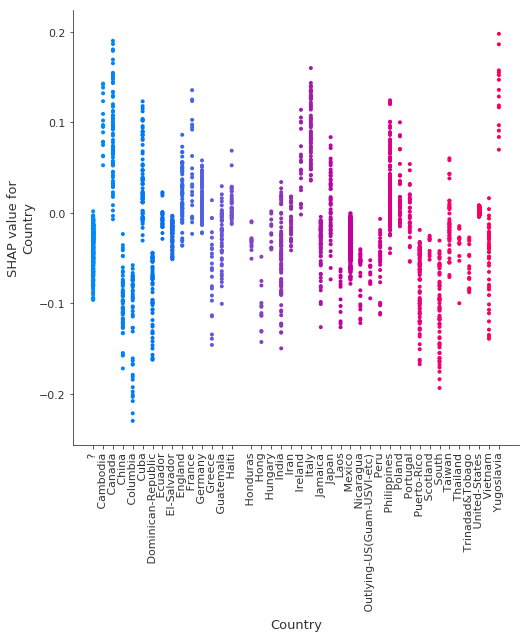

In [211]:
for col in X_train.columns:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    shap.dependence_plot(
        ind=col,
        shap_values=shap_values_reg_num_train,
        features=X_train_num,
        display_features=X_train,
        interaction_index=col,
        ax=ax)
    fig.savefig('dependence_plot_reg_only_{}.png'.format(col))